### Test of generating alternating single qubit and two qubit layers

In [1]:
vault_0 = {'0': 0.47, '7': 0.53}

vault_1 = {'1': 0.005, '3': 0.02, '4': 0.01, '5': 0.005, '6': 0.005, '9': 0.005, '10': 0.005, '11': 0.01, '12': 0.01, '14': 0.005, '15': 0.005, '18': 0.005,
 '19': 0.005, '23': 0.005, '25': 0.005, '27': 0.005, '29': 0.02, '30': 0.005, '31': 0.005, '32': 0.01, '33': 0.035, '34': 0.02, '35': 0.07, '36': 0.055, '37': 0.045,
 '38': 0.085, '39': 0.015, '42': 0.005, '43': 0.02, '44': 0.005, '45': 0.005, '46': 0.04, '47': 0.02, '48': 0.005, '49': 0.035, '50': 0.03,
 '51': 0.045, '52': 0.02, '53': 0.06, '54': 0.025, '55': 0.015, '57': 0.03, '58': 0.01, '59': 0.04, '60': 0.025, '61': 0.025, '62': 0.04, '63': 0.025}

vault_2 = {'0': 0.035, '1': 0.005, '2': 0.005, '5': 0.065, '6': 0.045, '7': 0.01, '8': 0.015, '9': 0.025, '10': 0.03, '11': 0.005, '12': 0.065,
 '13': 0.025, '14': 0.05, '15': 0.02, '16': 0.09, '17': 0.015, '18': 0.01, '19': 0.035, '20': 0.02, '21': 0.005, '23': 0.015, '25': 0.05,
 '27': 0.005, '28': 0.02, '29': 0.04, '30': 0.05, '31': 0.02, '32': 0.005, '33': 0.01, '34': 0.025, '35': 0.015, '36': 0.005, '38': 0.005,
 '40': 0.005, '41': 0.005, '42': 0.02, '43': 0.015, '45': 0.01, '49': 0.015, '52': 0.005, '54': 0.015, '56': 0.005, '58': 0.015, '59': 0.005, '60': 0.015,
 '61': 0.015, '62': 0.015}

vault_3 = {'95': 0.005, '245': 0.005, '397': 0.005, '399': 0.005, '405': 0.005, '423': 0.005, '424': 0.005, '494': 0.005, '503': 0.005, '683': 0.005, '739': 0.005,
 '746': 0.005, '749': 0.005, '754': 0.005, '757': 0.005, '823': 0.005, '853': 0.005, '867': 0.005, '872': 0.005, '874': 0.005, '875': 0.005, '878': 0.005,
 '882': 0.005, '883': 0.005, '884': 0.005, '886': 0.005, '895': 0.005, '909': 0.005, '918': 0.005, '938': 0.005, '975': 0.005, '1001': 0.005, '1005': 0.02,
 '1007': 0.005, '1013': 0.005, '1014': 0.005, '1067': 0.005, '1099': 0.005, '1131': 0.005, '1137': 0.005, '1145': 0.005, '1229': 0.005, '1230': 0.005,
 '1239': 0.005, '1261': 0.005, '1263': 0.005, '1265': 0.005, '1269': 0.01, '1291': 0.005, '1293': 0.005, '1296': 0.005, '1322': 0.005, '1325': 0.01, '1329': 0.005,
 '1331': 0.005, '1333': 0.005, '1335': 0.005, '1356': 0.005, '1358': 0.005, '1359': 0.005, '1360': 0.005, '1387': 0.005, '1389': 0.025, '1391': 0.005, '1393': 0.005,
 '1394': 0.005, '1397': 0.015, '1402': 0.01, '1405': 0.005, '1407': 0.005, '1411': 0.005, '1413': 0.005, '1415': 0.005, '1416': 0.01, '1421': 0.005, '1423': 0.005,
 '1426': 0.005, '1429': 0.005, '1432': 0.005, '1435': 0.005, '1455': 0.005, '1469': 0.005, '1509': 0.005, '1511': 0.01, '1512': 0.005, '1513': 0.005, '1514': 0.01,
 '1515': 0.06, '1516': 0.005, '1517': 0.065, '1518': 0.005, '1519': 0.035, '1520': 0.015, '1521': 0.01, '1522': 0.01, '1523': 0.025, '1525': 0.035, '1526': 0.005,
 '1527': 0.01, '1669': 0.005, '1769': 0.005, '1774': 0.005, '1855': 0.005, '1871': 0.005, '1899': 0.005, '1904': 0.005, '1905': 0.005, '1920': 0.005, '1963': 0.005,
 '2024': 0.005, '2027': 0.005, '2029': 0.005, '2031': 0.01, '2037': 0.005, '2162': 0.005, '2325': 0.005, '2539': 0.005, '2896': 0.005, '2917': 0.005, '3021': 0.005,
 '3024': 0.005, '3053': 0.005, '3375': 0.005, '3433': 0.005, '3435': 0.005, '3437': 0.005, '3442': 0.005, '3483': 0.005, '3491': 0.005, '3496': 0.005, '3561': 0.005,
 '3563': 0.005, '3565': 0.01, '3573': 0.015, '3575': 0.005, '3955': 0.005, '4086': 0.005}

vault_4 = {'72': 0.005, '116': 0.005, '180': 0.005, '181': 0.005, '186': 0.005, '187': 0.005, '188': 0.005, '233': 0.005, '244': 0.005, '308': 0.005,
 '317': 0.005, '328': 0.005, '346': 0.005, '354': 0.01, '373': 0.005, '418': 0.005, '434': 0.005, '442': 0.005, '471': 0.005, '495': 0.005, '598': 0.005,
 '718': 0.005, '725': 0.005, '738': 0.005, '746': 0.005, '763': 0.005, '796': 0.005, '828': 0.005, '842': 0.005, '858': 0.005, '882': 0.005, '958': 0.005,
 '976': 0.005, '989': 0.005, '1003': 0.005, '1127': 0.005, '1318': 0.005, '1358': 0.005, '1495': 0.005, '1513': 0.005, '1569': 0.005, '1576': 0.005, '1581': 0.005,
 '1634': 0.005, '1636': 0.005, '1642': 0.005, '1661': 0.005, '1698': 0.005, '1716': 0.005, '1738': 0.005, '1742': 0.005, '1766': 0.005, '1767': 0.005, '1770': 0.005,
 '1790': 0.005, '1826': 0.005, '1827': 0.005, '1838': 0.005, '1840': 0.005, '1842': 0.005, '1850': 0.005, '1885': 0.005, '1892': 0.005, '1897': 0.005, '1898': 0.005,
 '1966': 0.005, '1982': 0.005, '1984': 0.005, '1993': 0.005, '2004': 0.005, '2007': 0.005, '2025': 0.005, '2032': 0.005, '2035': 0.005, '2046': 0.005, '2090': 0.005,
 '2091': 0.005, '2114': 0.005, '2115': 0.005, '2146': 0.005, '2148': 0.005, '2153': 0.005, '2154': 0.01, '2155': 0.005, '2156': 0.005, '2168': 0.005, '2197': 0.005,
 '2212': 0.005, '2242': 0.005, '2290': 0.005, '2304': 0.005, '2347': 0.005, '2378': 0.005, '2451': 0.005, '2453': 0.005, '2459': 0.005, '2490': 0.005, '2544': 0.005,
 '2586': 0.005, '2600': 0.005, '2670': 0.005, '2676': 0.01, '2677': 0.005, '2680': 0.005, '2682': 0.005, '2690': 0.005, '2700': 0.005, '2706': 0.005, '2707': 0.005,
 '2711': 0.005, '2762': 0.005, '2819': 0.005, '2826': 0.005, '2827': 0.005, '2828': 0.005, '2844': 0.005, '2847': 0.005, '2854': 0.005, '2874': 0.005, '2880': 0.005,
 '2886': 0.005, '2890': 0.015, '2906': 0.005, '2973': 0.005, '3011': 0.005, '3022': 0.005, '3102': 0.005, '3106': 0.01, '3123': 0.005, '3138': 0.005, '3159': 0.005,
 '3162': 0.005, '3174': 0.005, '3200': 0.005, '3203': 0.005, '3219': 0.01, '3224': 0.01, '3228': 0.005, '3235': 0.005, '3238': 0.005, '3250': 0.005, '3252': 0.005,
 '3253': 0.005, '3264': 0.005, '3278': 0.005, '3290': 0.01, '3298': 0.005, '3305': 0.005, '3306': 0.005, '3352': 0.005, '3358': 0.005, '3362': 0.005, '3366': 0.005,
 '3367': 0.005, '3372': 0.005, '3374': 0.005, '3375': 0.005, '3380': 0.005, '3388': 0.005, '3394': 0.005, '3400': 0.005, '3402': 0.005, '3414': 0.01, '3418': 0.005,
 '3426': 0.01, '3427': 0.005, '3435': 0.005, '3436': 0.005, '3444': 0.01, '3450': 0.005, '3530': 0.005, '3560': 0.005, '3564': 0.005, '3571': 0.005, '3616': 0.005,
 '3701': 0.005, '3706': 0.005, '3709': 0.005, '3819': 0.005, '3845': 0.005, '3868': 0.005, '3874': 0.005, '3914': 0.01, '3916': 0.005, '3927': 0.005, '3956': 0.005,
 '4066': 0.005}

vault_5 = {'0': 0.13, '1': 0.12, '2': 0.11, '3': 0.11, '4': 0.17, '5': 0.15, '6': 0.095, '7': 0.115}

vault_6 = {'0': 0.01, '1': 0.025, '2': 0.01, '3': 0.015, '4': 0.015, '5': 0.005, '6': 0.025, '7': 0.025, '8': 0.02, '9': 0.01, '10': 0.025, '11': 0.01, '12': 0.01,
 '13': 0.015, '14': 0.015, '15': 0.015, '16': 0.02, '17': 0.005, '18': 0.02, '19': 0.02, '20': 0.015, '22': 0.005, '23': 0.025, '24': 0.005, '25': 0.01, '26': 0.015,
 '27': 0.035, '28': 0.015, '29': 0.025, '31': 0.005, '32': 0.005, '33': 0.02, '34': 0.01, '35': 0.005, '36': 0.055, '37': 0.025, '38': 0.015, '39': 0.035, '40': 0.005,
 '41': 0.025, '42': 0.025, '43': 0.01, '44': 0.025, '45': 0.025, '46': 0.02, '47': 0.015, '49': 0.015, '50': 0.01, '51': 0.015, '52': 0.01, '53': 0.015, '54': 0.015,
 '55': 0.015, '56': 0.01, '57': 0.015, '58': 0.005, '59': 0.02, '60': 0.02, '61': 0.015, '62': 0.02, '63': 0.01}

vault_7 = {'4': 0.005, '11': 0.005, '18': 0.005, '19': 0.01, '20': 0.01, '32': 0.005, '40': 0.005, '55': 0.005, '59': 0.005, '61': 0.005, '65': 0.005, '70': 0.005,
 '72': 0.005, '89': 0.005, '96': 0.005, '98': 0.005, '99': 0.005, '102': 0.005, '104': 0.005, '113': 0.005, '121': 0.01, '123': 0.005, '126': 0.005, '132': 0.005,
 '134': 0.005, '138': 0.005, '141': 0.005, '146': 0.005, '153': 0.005, '162': 0.005, '165': 0.005, '166': 0.005, '168': 0.005, '175': 0.005, '187': 0.005,
 '190': 0.005, '201': 0.005, '204': 0.005, '213': 0.005, '214': 0.005, '215': 0.005, '228': 0.005, '229': 0.005, '232': 0.005, '243': 0.005, '250': 0.005,
 '254': 0.005, '259': 0.005, '260': 0.005, '270': 0.005, '271': 0.005, '276': 0.005, '289': 0.005, '296': 0.005, '297': 0.005, '303': 0.005, '304': 0.005,
 '305': 0.005, '308': 0.005, '319': 0.005, '322': 0.005, '325': 0.005, '326': 0.005, '353': 0.005, '368': 0.01, '372': 0.005, '376': 0.005, '377': 0.005,
 '392': 0.005, '406': 0.005, '407': 0.005, '416': 0.005, '424': 0.01, '433': 0.005, '434': 0.005, '439': 0.005, '441': 0.005, '444': 0.005, '446': 0.005,
 '447': 0.005, '448': 0.005, '449': 0.005, '457': 0.005, '464': 0.005, '467': 0.005, '472': 0.005, '477': 0.005, '479': 0.005, '502': 0.005, '513': 0.005,
 '533': 0.005, '534': 0.005, '535': 0.005, '541': 0.005, '548': 0.005, '557': 0.005, '561': 0.005, '580': 0.005, '581': 0.005, '582': 0.01, '583': 0.01,
 '585': 0.005, '588': 0.005, '589': 0.01, '591': 0.005, '595': 0.005, '600': 0.005, '604': 0.005, '605': 0.005, '606': 0.005, '617': 0.005, '619': 0.005,
 '620': 0.005, '626': 0.005, '628': 0.005, '630': 0.005, '631': 0.005, '632': 0.01, '636': 0.005, '655': 0.005, '659': 0.005, '661': 0.005, '667': 0.005,
 '668': 0.01, '672': 0.005, '676': 0.005, '682': 0.005, '683': 0.005, '686': 0.005, '694': 0.005, '698': 0.005, '709': 0.01, '714': 0.01, '716': 0.005,
 '720': 0.005, '721': 0.005, '731': 0.005, '732': 0.005, '733': 0.005, '739': 0.005, '742': 0.005, '747': 0.01, '752': 0.005, '757': 0.01, '792': 0.005,
 '796': 0.005, '799': 0.005, '810': 0.005, '812': 0.005, '818': 0.005, '825': 0.005, '826': 0.005, '833': 0.005, '840': 0.005, '848': 0.005, '852': 0.005,
 '858': 0.005, '866': 0.005, '868': 0.005, '876': 0.005, '887': 0.005, '888': 0.005, '890': 0.005, '902': 0.01, '913': 0.01, '918': 0.005, '941': 0.005,
 '947': 0.005, '950': 0.005, '951': 0.005, '956': 0.005, '966': 0.005, '967': 0.01, '975': 0.005, '979': 0.005, '985': 0.005, '986': 0.005, '998': 0.005,
 '999': 0.005, '1000': 0.005, '1002': 0.005, '1012': 0.005, '1022': 0.005}

vault_8 = {'76': 0.005, '191': 0.005, '303': 0.005, '307': 0.005, '314': 0.005, '329': 0.005, '331': 0.005, '521': 0.005, '642': 0.005, '890': 0.005,
 '950': 0.005, '986': 0.005, '1050': 0.005, '1133': 0.005, '1163': 0.005, '1427': 0.005, '1539': 0.005, '1574': 0.005, '1590': 0.005, '1642': 0.005,
 '1671': 0.005, '1808': 0.005, '1937': 0.005, '1945': 0.005, '1969': 0.005, '2028': 0.005, '2112': 0.005, '2159': 0.005, '2219': 0.005, '2263': 0.005,
 '2348': 0.005, '2448': 0.005, '2604': 0.005, '2642': 0.005, '2662': 0.005, '2698': 0.005, '2811': 0.005, '3001': 0.005, '3050': 0.005, '3220': 0.005,
 '3276': 0.005, '3422': 0.005, '3438': 0.005, '3446': 0.005, '3654': 0.005, '3668': 0.005, '3725': 0.005, '3897': 0.005, '4004': 0.005, '4075': 0.005,
 '4149': 0.005, '4167': 0.005, '4334': 0.005, '4348': 0.005, '4423': 0.005, '4633': 0.005, '4741': 0.005, '4752': 0.005, '4851': 0.005, '4873': 0.005,
 '4887': 0.005, '4941': 0.005, '5110': 0.005, '5167': 0.005, '5209': 0.005, '5219': 0.005, '5658': 0.005, '5890': 0.005, '5897': 0.005, '5959': 0.005,
 '6022': 0.005, '6041': 0.005, '6282': 0.005, '6496': 0.005, '6524': 0.005, '6671': 0.005, '6787': 0.005, '6793': 0.005, '6941': 0.005, '6944': 0.005,
 '7024': 0.005, '7068': 0.005, '7117': 0.005, '7141': 0.005, '7160': 0.005, '7169': 0.005, '7186': 0.005, '7325': 0.005, '7430': 0.005, '7473': 0.005,
 '7560': 0.005, '7640': 0.005, '7678': 0.005, '8035': 0.005, '8213': 0.005, '8536': 0.005, '8549': 0.005, '8572': 0.005, '8665': 0.005, '8775': 0.005,
 '8927': 0.005, '8991': 0.005, '9283': 0.005, '9306': 0.005, '9313': 0.005, '9324': 0.005, '9338': 0.005, '9342': 0.005, '9375': 0.005, '9409': 0.005,
 '9436': 0.005, '9439': 0.005, '9457': 0.005, '9523': 0.005, '9609': 0.005, '9665': 0.005, '9680': 0.005, '9700': 0.005, '9875': 0.005, '9909': 0.005,
 '9935': 0.005, '10028': 0.005, '10059': 0.005, '10085': 0.005, '10107': 0.005, '10119': 0.005, '10125': 0.005, '10182': 0.005, '10484': 0.005, '10551': 0.005,
 '10582': 0.005, '10684': 0.005, '10700': 0.005, '10702': 0.005, '10753': 0.005, '10816': 0.005, '10924': 0.005, '10934': 0.005, '10987': 0.005, '11105': 0.005,
 '11170': 0.005, '11345': 0.005, '11346': 0.005, '11426': 0.005, '11429': 0.005, '11460': 0.005, '11532': 0.005, '11541': 0.005, '11702': 0.005, '11717': 0.005,
 '11736': 0.005, '11830': 0.005, '11882': 0.005, '11960': 0.005, '11962': 0.005, '12045': 0.005, '12112': 0.005, '12116': 0.005, '12685': 0.005, '12749': 0.005,
 '12788': 0.005, '12971': 0.005, '13003': 0.005, '13093': 0.005, '13208': 0.005, '13227': 0.005, '13333': 0.005, '13451': 0.005, '13581': 0.005, '13641': 0.005,
 '13728': 0.005, '13867': 0.005, '13893': 0.005, '14021': 0.005, '14194': 0.005, '14223': 0.005, '14254': 0.005, '14435': 0.005, '14446': 0.005, '14610': 0.005,
 '14613': 0.005, '14689': 0.005, '15064': 0.005, '15164': 0.005, '15205': 0.005, '15225': 0.005, '15306': 0.005, '15462': 0.005, '15472': 0.005, '15477': 0.005,
 '15609': 0.005, '15664': 0.005, '15764': 0.005, '15788': 0.005, '15982': 0.005, '15998': 0.005, '16003': 0.005, '16033': 0.005, '16193': 0.005, '16365': 0.005}

vault_9 = {'0': 0.155, '1': 0.755, '3': 0.09}

vault_10 = {'0': 0.255, '1': 0.005, '2': 0.05, '4': 0.64, '5': 0.005, '6': 0.045}

vault_11 = {'0': 0.025, '1': 0.015, '2': 0.005, '3': 0.02, '4': 0.01, '5': 0.02, '6': 0.02, '7': 0.015, '8': 0.215, '9': 0.225, '10': 0.145, '11': 0.065, '12': 0.04,
 '13': 0.05, '14': 0.08, '15': 0.05}

vault_12 = {'0': 0.005, '2': 0.005, '4': 0.015, '5': 0.01, '8': 0.025, '10': 0.015, '16': 0.03, '18': 0.08, '20': 0.01, '24': 0.595, '25': 0.015, '26': 0.175,
 '27': 0.01, '28': 0.005, '30': 0.005}

In [2]:
import qiskit
from qiskit import QuantumCircuit
import numpy as np
from utils.layers import alternating_sq_2q_layers

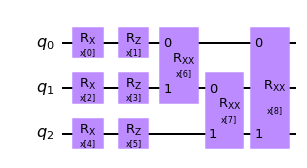

In [8]:
connectivity = [[0,1], [1,2], [0,2]]
circ = alternating_sq_2q_layers(3,1,'RXX', connectivity)
circ.draw('mpl')
# circ.draw('mpl')

In [7]:
# qasm convert
print(qiskit.qasm2.dumps(circ.assign_parameters(np.ones(14))))

OPENQASM 2.0;
include "qelib1.inc";
gate rzx(param0) q0,q1 { h q1; cx q0,q1; rz(param0) q1; cx q0,q1; h q1; }
qreg q[4];
rx(1.0) q[0];
rz(1.0) q[0];
rx(1.0) q[1];
rz(1.0) q[1];
rx(1.0) q[2];
rz(1.0) q[2];
rx(1.0) q[3];
rz(1.0) q[3];
rzx(1.0) q[0],q[1];
rzx(1.0) q[1],q[2];
rzx(1.0) q[2],q[3];
rzx(1.0) q[3],q[0];
rzx(1.0) q[1],q[3];
rzx(1.0) q[0],q[2];


In [16]:
# Given state dictionary
state = vault_3
# Find the maximum key value to determine the number of qubits required
max_key = max(map(int, state.keys()))
num_qubits = max_key.bit_length()
# Convert the keys to binary strings, padding them to ensure they match the length required by num_qubits
state_binary = {format(int(k), f'0{num_qubits}b'): v for k, v in state.items()}
# Display the binary representation and the number of qubits
print("Binary Representation:", state_binary)
print("Number of Qubits Required:", num_qubits)

Binary Representation: {'000001011111': 0.005, '000011110101': 0.005, '000110001101': 0.005, '000110001111': 0.005, '000110010101': 0.005, '000110100111': 0.005, '000110101000': 0.005, '000111101110': 0.005, '000111110111': 0.005, '001010101011': 0.005, '001011100011': 0.005, '001011101010': 0.005, '001011101101': 0.005, '001011110010': 0.005, '001011110101': 0.005, '001100110111': 0.005, '001101010101': 0.005, '001101100011': 0.005, '001101101000': 0.005, '001101101010': 0.005, '001101101011': 0.005, '001101101110': 0.005, '001101110010': 0.005, '001101110011': 0.005, '001101110100': 0.005, '001101110110': 0.005, '001101111111': 0.005, '001110001101': 0.005, '001110010110': 0.005, '001110101010': 0.005, '001111001111': 0.005, '001111101001': 0.005, '001111101101': 0.02, '001111101111': 0.005, '001111110101': 0.005, '001111110110': 0.005, '010000101011': 0.005, '010001001011': 0.005, '010001101011': 0.005, '010001110001': 0.005, '010001111001': 0.005, '010011001101': 0.005, '0100110011

In [178]:
from qiskit_algorithms.optimizers import L_BFGS_B, COBYLA
from qiskit_aer import StatevectorSimulator
from qiskit.quantum_info import Statevector
import qiskit.quantum_info as qi

intermediate_cost = []
intermediate_params = []

def cost(params, target, circ):
    '''
    target: dict
            count_dictionary obtained from the probe circuit
    params: 
    '''
    circ = circ.assign_parameters(params)
    result_dict = qi.Statevector.from_instruction(circ).probabilities_dict()


    reversed_dict = {}
    for key, value in result_dict.items():
        reversed_key = key[::-1]  # Reverse the key
        reversed_dict[reversed_key] = value
    
    sorted_keys = sorted(reversed_dict.keys(), key=lambda x: x[::-1])
    reversed_count_dict = {}
    # Populate the ordered dictionary with sorted keys
    for key in sorted_keys:
        reversed_count_dict[key[::-1]] = reversed_dict[key]
    
    cost = 0
    for (key1, value1), (key2, value2) in zip(target.items(), reversed_count_dict.items()):
        cost += ((value1-value2)**2)/ ((value1+value2)/2)
    
    intermediate_cost.append(cost)
    intermediate_params.append(params)
    return cost

def callback_func(params, target):
    cost_value = cost(params, target)  # Calculate the cost at the current iteration
    intermediate_cost.append(cost_value)
    intermediate_params.append(params)

c:\Users\c5517\python\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


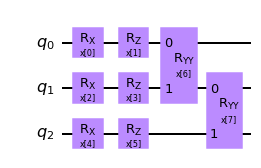

In [179]:
import torch
import torch.optim as optim
import qiskit.quantum_info as qi

connectivity = [[0,1],[1,2]]
circ = alternating_sq_2q_layers(3,1,'RYY', connectivity)
params = circ.num_parameters
# circ = alternating_sq_2q_layers(4,1,'RXX', connectivity, measurement=False).assign_parameters(params)
# target = qi.Statevector.from_instruction(circ).probabilities_dict()
# target
circ.draw('mpl')

c:\Users\c5517\python\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


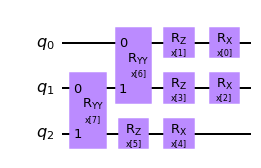

In [189]:
circ.reverse_ops().draw('mpl')

In [180]:
state = vault_5
# Find the maximum key value to determine the number of qubits required
max_key = max(map(int, state.keys()))
num_qubits = max_key.bit_length()
# Convert the keys to binary strings, padding them to ensure they match the length required by num_qubits
state_binary = {format(int(k), f'0{num_qubits}b'): v for k, v in state.items()}
state_binary

{'000': 0.13,
 '001': 0.12,
 '010': 0.11,
 '011': 0.11,
 '100': 0.17,
 '101': 0.15,
 '110': 0.095,
 '111': 0.115}

In [181]:
from scipy.optimize import minimize
parameters = [np.random.random() for _ in range(params)]
out = minimize(cost, x0=parameters, args = (state_binary, circ) ,method="L-BFGS-B", options={'maxiter':1000})
cost(out.jac,state_binary, circ)

3.0796460175666693

In [182]:
state_binary

{'000': 0.13,
 '001': 0.12,
 '010': 0.11,
 '011': 0.11,
 '100': 0.17,
 '101': 0.15,
 '110': 0.095,
 '111': 0.115}

In [165]:
cost(intermediate_params[np.argmin(intermediate_cost)],state_binary, circ)

1.4297328689630207e-09

In [185]:
connectivity = [[0,1]]
check = circ.assign_parameters(intermediate_params[np.argmin(intermediate_cost)])
check_result = qi.Statevector.from_instruction(check).probabilities_dict()
reversed_dict = {}
for key, value in check_result.items():
    reversed_key = key[::-1]  # Reverse the key
    reversed_dict[reversed_key] = value
    
sorted_keys = sorted(reversed_dict.keys(), key=lambda x: x[::-1])
reversed_count_dict = {}
# Populate the ordered dictionary with sorted keys
for key in sorted_keys:
    reversed_count_dict[key[::-1]] = reversed_dict[key]
reversed_count_dict

{'000': 0.1299999570360596,
 '001': 0.11999839584513868,
 '010': 0.10999948890933081,
 '011': 0.11000132741061144,
 '100': 0.17000087644914225,
 '101': 0.14999853215204742,
 '110': 0.09500169969930662,
 '111': 0.11499972249836285}

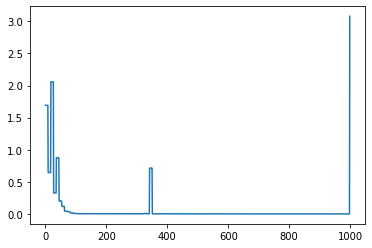

In [186]:
import matplotlib.pyplot as plt
plt.plot(intermediate_cost)